# 1D Particle-In-Cell code

This script contains a relativistic one-dimensional particle-in-cell code.
Run it and visualize the output. Images are saved in the ``./Data`` folder.
You can play with the input parameters to simulate different conditions of plasma and fields.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
import matplotlib.image as mpimg
import pylab as pl
from scipy.constants import e, m_e, c, epsilon_0, pi, m_p
import time
import os
import sys

# Update matplotlib configuration for better figure layout
matplotlib.rcParams.update({'figure.autolayout': True})

## Input Parameters

In [2]:
## UNITS ##
# Define parameters in SI units
lambda_SI = 0.8e-6
omega_SI = 2 * pi * c / lambda_SI

# Define conversions to adimensional units based on SI units
unit_time = 1 / omega_SI
unit_length = c / omega_SI
unit_E_field = m_e * c * omega_SI / e
unit_B_field = m_e * omega_SI / e
unit_velocity = c
unit_charge = e
unit_mass = m_e
unit_momentum = m_e * c
unit_density = epsilon_0 * m_e * omega_SI ** 2 / e ** 2
unit_current = unit_density * c * e
unit_energy = 2 * m_e ** 2 * c ** 4 / e ** 2 / lambda_SI
unit_weight = unit_density * unit_length

# Define commonly used units
micron = um = 1e-6 / unit_length
fs = 1e-15 / unit_time

In [3]:
## SPACE DISCRETIZATION ##
dx = um / 20  # Grid spacing
Lx = 60 * um  # Total length of the domain
x_min = 0  # Minimum x-coordinate
x_max = Lx  # Maximum x-coordinate

# Create array of grid points
nx = int(Lx / dx)  # Number of grid points
mx = nx + 2  # Total number of grid points (including guard cells on both edges)
x = x_min + np.arange(0, mx) * dx - dx  # Array of grid points along x-axis

In [4]:
## TIME DISCRETIZATION ##
cfl = 0.98  # CFL number
dt = cfl * dx  # Time step size
Tsim = 300 * fs  # Total simulation time in seconds
nt = int(Tsim / dt)  # Number of time steps

# Create array of time values and time step indices
t = np.arange(0, nt) * dt  # Array of time values
timesteps = np.arange(0, nt)  # Time step indices

In [5]:
## FIELD PARAMETERS ##
field_type = "inject_laser"  # "inject_laser" or "constant" 
field_boundary_conditions = "silver-muller"  # "silver-muller" or "periodic"
# Silver-Muller boundary conditions are absorbing conditions consistent with propagating waves

# constant: Ex0, Ey0, Ez0, Bx0, By0, Bz0
# inject_laser: a0, fwhm, laser_center, omega, k, polarization, temporal_profile
# inject laser requires Silver-Muller boundary conditions

In [6]:
## LASER PARAMETERS ##
a0 = 1  # Peak value of the normalized vector potential
# Calculate a0 from peak intensity using this formula:
# a0 = e * sqrt(2 * I_peak / (epsilon_0 * c)) / (omega_SI * m_e * c)

fwhm = 30 * fs  # Full width half maximum in intensity
laser_center = 2 * fwhm  # Temporal centering of the laser
omega = 1  # Laser Frequency
k = 1  # Wavenumber of the laser
polarization = "EyBz" # Laser polarization ("EyBz","EzBy" or "EyEzByBz")
temporal_profile = "gaussian"  # Profile of the laser pulse ("gaussian" or "cos2")

In [7]:
## PLASMA PARAMETERS ##

# Atomic and mass numbers
ZC = 6
AC = 12
Zp = 1
Ap = 1

# Define lists of particle species properties
names = ['ELE', 'ION']
charges = [-1, Zp]
masses = [1, 1836 * Ap]

# Define density profiles
density_type = ["uniform" , "uniform"]  # "none", uniform" or "trapezoidal"

# none: no parameters required
# uniform: xa,xb,n0 
# trapezoidal: xa,xb,left_ramp,right_ramp,n0

ne0 = 1e-2  # Initial electron density

density_parameters = [ [0.4 * Lx, 0.6 * Lx, ne0],
                      [0.4 * Lx, 0.6 * Lx, ne0 / Zp]]  

nppc = [2, 2]  # Number of particles per cell

# Define momentum distribution
momentum_type = [ "cold", "cold" ]  # "waterbag", "maxwell_boltzmann" or "cold"

# waterbag: P0x, dPx, P0y, dPy, P0z, dPz
# maxwell-boltzmann: P0x, Tx, P0y, Ty, P0z, Tz (Tx,Ty,Tz in units of me c^2)
# cold: no parameters required

momentum_parameters = [ [0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0]]  

In [8]:
## DIAGNOSTICS ##
# Define interval for printing diagnostic output, in terms of time steps
every_fs = int(fs / dt)
out_freq = 20 * every_fs
unit_SI = False # Define the units of the plots

## Core Classes of the 1D PIC Algorithm

In [9]:
class EMfield:
    def __init__(self):
        """
        Initializes the EMfield object.

        If the field type is 'inject_laser', it initializes the fields based on the specified parameters.
        If the field type is 'constant', it sets all fields to constant values.
        Raises exceptions for invalid field types, polarizations, and temporal profiles.
        """
        if field_type == "inject_laser":
            sign_k = (k > 0) - (k < 0)
            x_0 = -dx
            t_0 = dt / 2
            self.Ex = np.zeros(x.size)
            self.Ey = np.zeros(x.size)
            self.Ez = np.zeros(x.size)
            self.Bx = np.zeros(x.size)
            self.By = np.zeros(x.size)
            self.Bz = np.zeros(x.size)
            # Define the F1 and F2 fields of the laser to be inject through Silver-Muller boundary conditions 
            if polarization == 'EyBz':
                self.F1 = np.zeros(t.size)
                self.F2 = sign_k * np.sin(k * x_0 - omega * (t - laser_center + t_0))
            elif polarization == 'EzBy':
                self.F1 = -sign_k * np.sin(k * x_0 - omega * (t - laser_center + t_0))
                self.F2 = np.zeros(t.size)
            elif polarization == 'EyEzByBz':
                self.F1 = -1 / np.sqrt(2) * sign_k * np.sin(k * x_0 - omega * (t - laser_center + t_0))
                self.F2 = 1 / np.sqrt(2) * sign_k * np.cos(k * x_0 - omega * (t - laser_center + t_0))
            else:
                raise Exception("Invalid polarization!")
            if temporal_profile == "gaussian":
                self.F1 *= self.gaussian(x_0, t - laser_center + t_0)
                self.F2 *= self.gaussian(x_0, t - laser_center + t_0)
            elif temporal_profile == "cos2":
                self.F1 *= self.cos2(x_0, t - laser_center + t_0)
                self.F2 *= self.cos2(x_0, t - laser_center + t_0)
            else:
                raise Exception("Invalid temporal_profile!")
        elif field_type == "constant":
            self.Ex = np.ones(x.size) * Ex0
            self.Ey = np.ones(x.size) * Ey0
            self.Ez = np.ones(x.size) * Ez0
            self.Bx = np.ones(x.size) * Bx0
            self.By = np.ones(x.size) * By0
            self.Bz = np.ones(x.size) * Bz0
        else:
            raise Exception("Invalid field_type!")
    
    def gaussian(self, x, time):
        """
        Computes the Gaussian function at the given position and time.

        Args:
            x (float): Position.
            time (float): Time.

        Returns:
            float: Value of the Gaussian function at the given position and time.
        """
        sigma = fwhm / (2 * np.sqrt(np.log(2)))
        return a0 * np.exp(-(-k * x + omega * time) ** 2 / sigma ** 2)


    def cos2(self, x, time):
        """
        Computes the cos^2 function at the given position and time.

        Args:
            x (float): Position.
            time (float): Time.

        Returns:
            float: Value of the cos^2 function at the given position and time.
        """
        sigma = fwhm / (pi / 2)
        return a0 * np.cos(1 / sigma * (k * x - omega * time)) ** 2 * (np.abs(k * x - omega * time) < fwhm)


    def update_B(self, dt):
        """
        Updates the magnetic field based on the electric field.

        Args:
            dt (float): Time step.

        Returns:
            None
        """
        self.Bx[:-1] = self.Bx[:-1]
        self.By[:-1] += dt / dx * (self.Ez[1:] - self.Ez[:-1])
        self.Bz[:-1] -= dt / dx * (self.Ey[1:] - self.Ey[:-1])
        
    def update_E(self, J):
        """
        Updates the electric field based on the magnetic field and current density.

        Args:
            J (object): Object containing current density components.

        Returns:
            None
        """
        self.Ex[:-1] -= dt * J.Jx[:-1]
        self.Ey[1:] -= dt/dx * (self.Bz[1:] - self.Bz[:-1]) + dt * J.Jy[1:]
        self.Ez[1:] += dt/dx * (self.By[1:] - self.By[:-1]) - dt * J.Jz[1:]

    def boundary_conditions_E(self):
        """
        Applies boundary conditions to the electric field.

        Raises exceptions for invalid field types and boundary conditions.

        Returns:
            None
        """
        if field_boundary_conditions == "periodic":
            if field_type == "inject_laser":
                raise Exception("Invalid field_type for periodic boundary conditions!")
            self.Ex[mx-1] = self.Ex[0]
            self.Ey[0] = self.Ey[mx-1]
            self.Ez[0] = self.Ez[mx-1]
        elif field_boundary_conditions == "silver-muller":
            self.Ex[mx-1] = self.Ex[0]
            self.Ey[0] = (1 - 2 * dt / (dt + dx)) * self.Ey[0] - 2 * dt / (dt + dx) * self.Bz[0]
            self.Ez[0] = (1 - 2 * dt / (dt + dx)) * self.Ez[0] + 2 * dt / (dt + dx) * self.By[0]
            if field_type == "inject_laser":
                self.Ey[0] += 4 * dt / (dx+dt) * self.F2[timestep]
                self.Ez[0] += 4 * dt / (dx+dt) * self.F1[timestep]
        else:
            raise Exception("Invalid field_boundary_conditions!")

    def boundary_conditions_B(self):
        """
        Applies boundary conditions to the magnetic field.

        Raises exceptions for invalid field types and boundary conditions.

        Returns:
            None
        """
        if field_boundary_conditions == "periodic":
            if field_type == "inject_laser":
                raise Exception("Invalid field_type for periodic boundary conditions!")
            self.Bx[0] = self.Bx[mx-1]
            self.By[mx-1] = self.By[0]
            self.Bz[mx-1] = self.Bz[0]
        elif field_boundary_conditions == "silver-muller":
            self.Bx[0] = self.Bx[mx-1]
            self.By[mx-1] = (1 - 2 * dt / (dt + dx)) * self.By[mx-1] - 2 * dt / (dt + dx) * self.Ez[mx-1]
            self.Bz[mx-1] = (1 - 2 * dt / (dt + dx)) * self.Bz[mx-1] + 2 * dt / (dt + dx) * self.Ey[mx-1]
        else:
            raise Exception("Invalid field_boundary_conditions!")

    def calculate_energy(self):
        """
        Calculates the energy of the electromagnetic field.

        Returns:
            float: Total energy of the electromagnetic field.
        """
        return dx / 2 * np.sum(self.Ex ** 2 + self.Ey ** 2 + self.Ez ** 2 +
                               self.Bx ** 2 + self.By ** 2 + self.Bz ** 2)


    def energy_save(self, timestep):
        """
        Saves the energy of the fields to a file.

        Args:
            timestep (int): Current timestep.

        Returns:
            None
        """
        energy = self.calculate_energy()
        path = './Data/EM_energy.txt'
        if (timestep == 0 and os.path.exists(path)):
            os.remove(path)
        append_new_line(path, '%e %e' % (timestep * dt, energy))

        
    def print_EMfield(self, t):
        """
        Saves the electromagnetic fields to a file at a specific time.

        Args:
            t (float): Time.

        Returns:
            None
        """
        np.savetxt('./Data/EM_fields_%s.txt' % t, np.c_[self.Ex, self.Ey, self.Ez, self.Bx, self.By, self.Bz])

    def plot_EMfield(self, t, unitSI=False):
        """
        Plots the electromagnetic fields at a specific time and saves the plots to files.

        Args:
            t (float): Time.
            unitSI (bool, optional): Whether to use SI units for plotting. Defaults to False.

        Returns:
            None
        """
        for Efield, label in zip([self.Ex, self.Ey, self.Ez], ['E_x', 'E_y', 'E_z']):
            if label == 'E_x':
                xplot = x + 0.5 * dx
            else:
                xplot = x
            xvar = xplot
            yvar = Efield
            fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
            if unitSI:
                xvar = xvar * unit_length
                yvar = yvar * unit_E_field
            ax.plot(xvar[1:-1], yvar[1:-1])
            if unitSI:
                ax.set(ylabel='$%s$ [V/m]' % label, xlabel='x [m]')
                ax.set_title('Time = %d fs'%(t*dt*unit_time)) 
            else:
                ax.set(ylabel='$%s$ [$m_ec\omega/e$]' % label, xlabel='x [$c/\omega$]')
                ax.set_title('Time = %d $1/\omega$'%(t*dt))
            fig.savefig('./Data/%s_%s.png' % (label, t))
            plt.close()
        for Bfield, label in zip([self.Bx, self.By, self.Bz], ['B_x', 'B_y', 'B_z']):
            if label == 'B_x':
                xplot = x
            else:
                xplot = x + 0.5 * dx
            xvar = xplot
            yvar = Bfield
            fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
            if unitSI:
                xvar = xvar * unit_length
                yvar = yvar * unit_B_field
            ax.plot(xvar[1:-1], yvar[1:-1])
            if unitSI:
                ax.set(ylabel='$%s$ [T]' % label, xlabel='x [m]')
                ax.set_title('Time = %d fs'%(t*dt*unit_time))               
            else:
                ax.set(ylabel='$%s$ [$m_e\omega/e$]' % label, xlabel='x [$c/\omega$]')
                ax.set_title('Time = %d $1/\omega$'%(t*dt))
            fig.savefig('./Data/%s_%s.png' % (label, t))
            plt.close()

In [10]:
class Densities:
    def __init__(self, species, Jx0=0, Jy0=0, Jz0=0):
        """
        Initializes the Densities object containing rho and J field for each species.
        
        Raises exceptions for invalid density types.

        Args:
            species (object): Species object.
            Jx0 (float, optional): Initial current density along x-axis. Defaults to 0.
            Jy0 (float, optional): Initial current density along y-axis. Defaults to 0.
            Jz0 (float, optional): Initial current density along z-axis. Defaults to 0.

        Returns:
            None
        """
        self.rho = np.zeros(x.size)
        self.Jx = np.ones(x.size) * Jx0
        self.Jy = np.ones(x.size) * Jy0
        self.Jz = np.ones(x.size) * Jz0
        if species.density_type == "uniform":
            xa = species.density_parameters[0]
            xb = species.density_parameters[1]
            n0 = species.density_parameters[2]
            self.rho = (x[1:mx-1] >= xa) * (x[1:mx-1] <= xb) * n0 * species.q
        elif species.density_type == "trapezoidal":
            xa = species.density_parameters[0]
            xb = species.density_parameters[1]
            xa1 = species.density_parameters[2]
            xb1 = species.density_parameters[3]
            n0 = species.density_parameters[4]
            self.rho = n0 * species.q * (x[1:mx-1] >= xa) * (x[1:mx-1] < xa1) * ((x[1:mx-1] - xa) / (xa1 - xa)) + \
               (x[1:mx-1] >= xa1) * (x[1:mx-1] < xb1)+ \
               (x[1:mx-1] >= xb1) * (x[1:mx-1] <= xb) * ((x[1:mx-1] - xb1) / (xb1 - xb) + 1)
        else:
            raise Exception("Invalid density_type!")

    def charge_deposition(self, species):
        """
        Deposits charge onto the grid from particle positions.

        Args:
            species (object): Species object containing particle data.

        Returns:
            None
        """
        self.rho = np.zeros(x.size)
        for xp, w in zip(species.xp,species.w):
            # Find the nearest grid point
            index = int(np.floor((xp-x[0])/dx+0.5))
            dist = (xp - x[index]) / dx
            dist2 = dist ** 2
            # Project the charge on the nearest grid points with proper weights
            self.rho[index - 1] += species.q * w * 0.5 * (dist2 - dist + 0.25) / dx
            self.rho[index] += species.q * w * (0.75 - dist2) / dx
            self.rho[index + 1] += species.q * w * 0.5 * (dist2 + dist + 0.25) / dx

        
    def current_deposition(self, species):
        """
        Deposits current onto the grid from particle positions and momenta.

        Args:
            species (object): Species object containing particle data.

        Returns:
            None
        """
        self.Jx = np.zeros(x.size)
        self.Jy = np.zeros(x.size)
        self.Jz = np.zeros(x.size)
        m = species.m
        q = species.q
        for xp, px, py, pz, w in zip(species.xp,species.px,species.py,species.pz,species.w):
            # Find the nearest grid points on the two staggered grids
            dist_i = (xp-x[0])/dx
            dist_h = dist_i - 0.5
            index_i = int(np.floor(dist_i+0.5))
            index_h = int(np.floor(dist_h+0.5))
            dist_i -= index_i
            dist2_i = dist_i**2
            dist_h -= index_h
            dist2_h = dist_h**2
            # Calculate the weights for the nearest grid points
            w_i_l = 0.5 * (0.25 + dist2_i - dist_i)
            w_i_c = 0.75 - dist2_i
            w_i_r = 0.5 * (0.25 + dist2_i + dist_i)
            w_h_l = 0.5 * (0.25 + dist2_h - dist_h)
            w_h_c = 0.75 - dist2_h
            w_h_r = 0.5 * (0.25 + dist2_h + dist_h)
            # Project the current on nearest grid points
            gamma = np.sqrt(1 + (px * px + py * py + pz * pz) / (m * m))
            self.Jx[index_h - 1] += q * w * px / gamma / dx / m * w_h_l
            self.Jx[index_h] += q * w * px / gamma / dx / m * w_h_c
            self.Jx[index_h + 1] += q * w * px / gamma / dx / m * w_h_r
            self.Jy[index_i - 1] += q * w * py / gamma / dx / m * w_i_l
            self.Jy[index_i] += q * w * py / gamma / dx / m * w_i_c
            self.Jy[index_i + 1] += q * w * py / gamma / dx / m * w_i_r    
            self.Jz[index_i - 1] += q * w * pz / gamma / dx / m * w_i_l
            self.Jz[index_i] += q * w * pz / gamma / dx / m * w_i_c
            self.Jz[index_i + 1] += q * w * pz / gamma / dx / m * w_i_r
            
    def periodic_boundary_conditions_J(self): 
        """
        Applies periodic boundary conditions to J field.
        """
        self.Jx[1] += self.Jx[-1]
        self.Jx[-2] += self.Jx[0]        
        self.Jx[0] = self.Jx[-2]
        self.Jx[-1] = self.Jx[1]

        self.Jy[1] += self.Jy[-1]
        self.Jy[-2] += self.Jy[0]        
        self.Jy[0] = self.Jy[-2]
        self.Jy[-1] = self.Jy[1] 

        self.Jz[1] += self.Jz[-1]
        self.Jz[-2] += self.Jz[0]        
        self.Jz[0] = self.Jz[-2]
        self.Jz[-1] = self.Jz[1]

    def plot_rho(self, species, t, unitSI=False):
        """
        Plots charge density.

        Args:
            species (object): Species object.
            t (float): Current time.
            unitSI (bool, optional): Flag for using SI units. Defaults to False.

        Returns:
            None
        """
        xvar = x.copy()
        yvar = self.rho.copy()
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
        if unitSI:
            xvar = xvar * unit_length
            yvar = yvar * unit_current
        ax.plot(xvar[1:-1], yvar[1:-1])
        if unitSI:
            ax.set(ylabel=r'$\rho$ [C/$m^3$]', xlabel='x [m]')
            ax.set_title(species.name+' Time = %d fs'%(t*dt*unit_time))
        else:
            ax.set(ylabel=r'$\rho$ [$m_e\omega^2/(4 \pi e)$]', xlabel='x [$c/\omega$]')

            ax.set_title(species.name+' Time = %d $1/\omega$'%(t*dt))
        fig.savefig('./Data/%s_rho_%s.png' % (species.name, t))
        plt.close()

    def save_rho(self, species, t):
        """
        Saves charge density data to a text file.

        Args:
            species (object): Species object.
            t (float): Current time.

        Returns:
            None
        """
        xvar = x.copy()
        yvar = self.rho.copy()
        np.savetxt('./Data/%s_rho_%s.txt' % (species.name, t), np.c_[xvar, yvar])

In [11]:
class Species:
    def __init__(self, name, q, m, density_type, density_parameters, nppc, momentum_type, momentum_parameters, xp=[], px=[], py=[], pz=[], w=[]):
        """
        Initializes the Species object.

        Args:
            name (str): Name of the species.
            q (float): Charge of the species.
            m (float): Mass of the species.
            density_type (str): Type of density profile.
            density_parameters (list): Parameters for the density profile.
            nppc (int): Number of particles per cell.
            momentum_type (str): Type of momentum initialization.
            momentum_parameters (list): Parameters for the momentum initialization.
            xp (list, optional): Particle positions. Defaults to [].
            px (list, optional): Particle momenta along x-axis. Defaults to [].
            py (list, optional): Particle momenta along y-axis. Defaults to [].
            pz (list, optional): Particle momenta along z-axis. Defaults to [].
            w (list, optional): Particle weights. Defaults to [].

        Returns:
            None
        """
        self.name = name
        self.q = q
        self.m = m
        self.xp = np.array(xp)
        self.px = np.array(px)
        self.py = np.array(py)
        self.pz = np.array(pz)
        self.w = np.array(w)
        self.Ex = np.zeros(self.xp.size)
        self.Ey = np.zeros(self.xp.size)
        self.Ez = np.zeros(self.xp.size)
        self.Bx = np.zeros(self.xp.size)
        self.By = np.zeros(self.xp.size)
        self.Bz = np.zeros(self.xp.size)
        if density_type != "none":
            self.density_type = density_type
            self.density_parameters = density_parameters
            self.momentum_type = momentum_type
            self.momentum_parameters = momentum_parameters
            self.nppc = nppc
            self.densities = Densities(self)
            self.add_density()

    def add_particles(self, x, px, py, pz, w):
        """
        Adds particles to the species.

        Args:
            x (float or array-like): Particle positions along the x-axis.
            px (float or array-like): Particle momenta along the x-axis.
            py (float or array-like): Particle momenta along the y-axis.
            pz (float or array-like): Particle momenta along the z-axis.
            w (float or array-like): Particle weights.

        Returns:
            None
        """
        self.xp = np.append(self.xp, x)
        self.px = np.append(self.px, px)
        self.py = np.append(self.py, py)
        self.pz = np.append(self.pz, pz)
        self.w = np.append(self.w, w)

    def add_density(self):  
        """
        Adds particles based on density profile.
        
        Raises exceptions for invalid momentum distributions.

        Returns:
            None
        """
        for i, xcell in enumerate(x[1:mx-1]):
            positions = np.array([])
            if self.densities.rho[i] != 0:
                for j in range(self.nppc):
                    positions = np.append(positions, xcell - dx / 2 + j * dx / (self.nppc + 1))
            if self.momentum_type == "cold":
                px = np.zeros(positions.size)
                py = np.zeros(positions.size)
                pz = np.zeros(positions.size)
            elif self.momentum_type == "waterbag":
                [px, py, pz] = self.waterbag(positions.size)
            elif self.momentum_type == "maxwell_boltzmann":
                [px, py, pz] = self.maxwell_boltzmann(positions.size)
            else:
                raise Exception("Invalid momentum_type!")
            w = np.ones(positions.size) * self.densities.rho[i] / self.q * dx / self.nppc
            self.add_particles(positions, px, py, pz, w)

    def waterbag(self, size):
        """
        Generates waterbag momentum distribution.

        Args:
            size (int): Size of the momentum arrays.

        Returns:
            tuple: Arrays containing momentum components.
        """
        rng = np.random.default_rng(417)
        px = self.momentum_parameters[0] + (2 * rng.random(size) - 1) * self.momentum_parameters[1]
        py = self.momentum_parameters[2] + (2 * rng.random(size) - 1) * self.momentum_parameters[3]
        pz = self.momentum_parameters[4] + (2 * rng.random(size) - 1) * self.momentum_parameters[5]
        return px, py, pz

    def maxwell_boltzmann(self, size):
        """
        Generates Maxwell-Boltzmann momentum distribution.

        Args:
            size (int): Size of the momentum arrays.

        Returns:
            tuple: Arrays containing momentum components.
        """
        rng = np.random.default_rng(2024)
        px = np.random.normal(self.momentum_parameters[0], self.m * self.momentum_parameters[1], size)
        py = np.random.normal(self.momentum_parameters[2], self.m * self.momentum_parameters[3], size)
        pz = np.random.normal(self.momentum_parameters[4], self.m * self.momentum_parameters[5], size)
        return px, py, pz

    def field_gathering(self, field):
        """
        Gathers electric and magnetic field values at particle positions.

        Args:
            field (EMfield): Electromagnetic field object.

        Returns:
            None
        """
        self.Ex = np.zeros(self.xp.size)
        self.Ey = np.zeros(self.xp.size)
        self.Ez = np.zeros(self.xp.size)
        self.Bx = np.zeros(self.xp.size)
        self.By = np.zeros(self.xp.size)
        self.Bz = np.zeros(self.xp.size)
        for i, xp in enumerate(self.xp):
            # Find nearest grid points
            dist_i = (xp-x[0])/dx
            dist_h = dist_i - 0.5
            index_i = int(np.floor(dist_i+0.5))
            index_h = int(np.floor(dist_h+0.5))
            dist_i -= index_i
            dist2_i = dist_i**2
            dist_h -= index_h
            dist2_h = dist_h**2
            # Calculate the weights for the nearest grid points
            w_i_l = 0.5 * (0.25 + dist2_i - dist_i)
            w_i_c = 0.75 - dist2_i
            w_i_r = 0.5 * (0.25 + dist2_i + dist_i)
            w_h_l = 0.5 * (0.25 + dist2_h - dist_h)
            w_h_c = 0.75 - dist2_h
            w_h_r = 0.5 * (0.25 + dist2_h + dist_h)
            # Interpolate fron nearest grid points using the calculated weights
            self.Ex[i] = w_h_l * field.Ex[index_h - 1] + w_h_c * field.Ex[index_h] + w_h_r * field.Ex[index_h + 1]
            self.Ey[i] = w_i_l * field.Ey[index_i - 1] + w_i_c * field.Ey[index_i] + w_i_r * field.Ey[index_i + 1]
            self.Ez[i] = w_i_l * field.Ez[index_i - 1] + w_i_c * field.Ez[index_i] + w_i_r * field.Ez[index_i + 1]
            self.Bx[i] = w_i_l * field.Bx[index_i - 1] + w_i_c * field.Bx[index_i] + w_i_r * field.Bx[index_i + 1]   
            self.By[i] = w_h_l * field.By[index_h - 1] + w_h_c * field.By[index_h] + w_h_r * field.By[index_h + 1]
            self.Bz[i] = w_h_l * field.Bz[index_h - 1] + w_h_c * field.Bz[index_h] + w_h_r * field.Bz[index_h + 1]       
            
    def advance_position(self, dt):
        """
        Advances particle positions using the relativistic equation of motion.

        Args:
            dt (float): Time step.

        Returns:
            None
        """
        gamma = np.sqrt(1 + (self.px ** 2 + self.py ** 2 + self.pz ** 2) / self.m ** 2)
        self.xp += dt / self.m * self.px / gamma

    def advance_momentum(self):
        """
        Advances particle momenta using the Boris pusher.

        Args:
            None

        Returns:
            None
        """
        const1 = self.q * dt / 2
        const2 = self.q / self.m * dt / 2
        ptx = self.px + const1 * self.Ex
        pty = self.py + const1 * self.Ey
        ptz = self.pz + const1 * self.Ez
        gamma = np.sqrt(1 + (ptx ** 2 + pty ** 2 + ptz ** 2) / self.m ** 2)
        bx = const2 * self.Bx / gamma
        by = const2 * self.By / gamma
        bz = const2 * self.Bz / gamma
        b2 = bx ** 2 + by ** 2 + bz ** 2
        pnx = (ptx + pty * bz - ptz * by + (ptx * bx + pty * by + ptz * bz) * bx) / (1 + b2)
        pny = (pty - ptx * bz + ptz * bx + (ptx * bx + pty * by + ptz * bz) * by) / (1 + b2)
        pnz = (ptz + ptx * by - pty * bx + (ptx * bx + pty * by + ptz * bz) * bz) / (1 + b2)
        self.px = 2 * pnx - self.px
        self.py = 2 * pny - self.py
        self.pz = 2 * pnz - self.pz

    def boundary_conditions_particles(self):
        """
        Applies periodic boundary conditions to particle positions.

        Args:
            None

        Returns:
            None
        """
        for i, xp in enumerate(self.xp):
            index = int(np.floor((xp - x[0]) / dx + 0.5))
            if index == 0:
                self.xp[i] += Lx
            elif index == mx - 1:
                self.xp[i] -= Lx

    def print_species(self):
        """
        Prints the parameters of the species.

        Args:
            None

        Returns:
            None
        """
        print('\n**SPECIES %s PARAMETERS**' % (self.name))
        print('Charge: %e C' % (self.q * unit_charge))
        print('Mass: %e kg' % (self.m * unit_mass))
        print('Number of Particles: %d\n' % (self.w.size))

    def save_species(self, t):
        """
        Saves the species data to a text file.

        Args:
            t (float): Current time.

        Returns:
            None
        """
        np.savetxt('./Data/%s_%s.txt' % (self.name, t), np.c_[self.xp, self.px, self.py, self.pz, self.w],
                   header='q:%e, m:%e, N:%d - x,px,py,pz,w' % (self.q, self.m, self.w.size))

    def kinetic_energy(self):
        """
        Calculates the kinetic energy of the species.

        Returns:
            float: Total kinetic energy.
        """
        gamma = np.sqrt(1 + (self.px ** 2 + self.py ** 2 + self.pz ** 2) / self.m ** 2)
        return np.sum((gamma - 1) * self.w * self.m)

    def kinetic_energy_save(self, timestep):
        """
        Saves the kinetic energy of the species to a file.

        Args:
            timestep (int): Current timestep.

        Returns:
            None
        """
        energy = self.kinetic_energy()
        path = './Data/kinetic_energy_%s.txt' % self.name
        if timestep == 0 and os.path.exists(path):
            os.remove(path)
        append_new_line(path, '%e %e' % (timestep * dt, energy))

    def scatter_species_position(self, t, unitSI=False):
        """
        Scatter plots the positions of particles of the species.

        Args:
            t (int): Current time.
            unitSI (bool, optional): Whether to use SI units. Defaults to False.

        Returns:
            None
        """
        xvar = self.xp.copy()
        yvar = self.w.copy()
        if unitSI:
            xvar *= unit_length
            yvar *= unit_weight
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
        ax.scatter(xvar, yvar, marker='.')
        if unitSI:
            ax.set(ylabel='w [1/$m^2$]', xlabel='x [m]')
            ax.set_xlim([x[1:-1].min() * unit_length, x[1:-1].max() * unit_length])
            ax.set_title(self.name+' Time = %d fs'%(t*dt*unit_time))
        else:
            ax.set(ylabel='w [$n_c c/\omega$]', xlabel='x [$c/\omega$]')
            ax.set_xlim([x[1:-1].min(), x[1:-1].max()])
            ax.set_title(self.name+' Time = %d $1/\omega$'%(t*dt))           
        fig.savefig('./Data/%s_pos_%s.png' % (self.name, t))
        plt.close()

    def scatter_species_momentum(self, t, unitSI=False):
        """
        Scatter plots the momentum components of particles of the species.

        Args:
            t (int): Current time.
            unitSI (bool, optional): Whether to use SI units. Defaults to False.

        Returns:
            None
        """
        xvar = self.px.copy()
        yvar = self.py.copy()
        if unitSI:
            xvar *= unit_momentum
            yvar *= unit_momentum
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
        ax.scatter(xvar, yvar, marker='.')
        if unitSI:
            ax.set(ylabel='py [kg m/s]', xlabel='px [kg m/s]')
            ax.set_title(self.name+' Time = %d fs'%(t*dt*unit_time))
        else:
            ax.set(ylabel='py [$m_e c$]', xlabel='px [$m_e c$]')
            ax.set_title(self.name+' Time = %d $1/\omega$'%(t*dt))
        ax.set_xlim([xvar.min(), xvar.max()+1])
        ax.set_ylim([yvar.min(), yvar.max()+1])
        fig.savefig('./Data/%s_mom_%s.png' % (self.name, t))
        plt.close()

In [12]:
class Jfield:
    def __init__(self, Jx0=0, Jy0=0, Jz0=0):
        """
        Initializes the Jfield object containing the total J field.

        Args:
            Jx0 (float, optional): Initial current density along x-axis. Defaults to 0.
            Jy0 (float, optional): Initial current density along y-axis. Defaults to 0.
            Jz0 (float, optional): Initial current density along z-axis. Defaults to 0.

        Returns:
            None
        """
        self.Jx = np.ones(x.size) * Jx0
        self.Jy = np.ones(x.size) * Jy0
        self.Jz = np.ones(x.size) * Jz0

    def add_to_Jfield(self, species):
        """
        Adds current density from a species to the Jfield.

        Args:
            species (Species): Species object.

        Returns:
            None
        """
        self.Jx += species.densities.Jx
        self.Jy += species.densities.Jy
        self.Jz += species.densities.Jz
        
    def print_Jfield(self, t):
        """
        Prints the current density to a file.

        Args:
            t (int): Current time step.

        Returns:
            None
        """
        np.savetxt('./Data/J_field_%s.txt' % t, np.c_[self.Jx, self.Jy, self.Jz])

    def plot_Jfield(self, t, unitSI=False):
        """
        Plots the current density.

        Args:
            t (int): Current time step.
            unitSI (bool, optional): Whether to use SI units. Defaults to False.

        Returns:
            None
        """
        for Jfield, label in zip([self.Jx, self.Jy, self.Jz], ['J_x', 'J_y', 'J_z']):
            if label == 'J_x':
                xplot = x + 0.5 * dx
            else:
                xplot = x
            xvar = xplot
            yvar = Jfield
            fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
            if unitSI:
                xvar = xvar * unit_length
                yvar = yvar * unit_density * unit_charge
            ax.plot(xvar[1:-1], yvar[1:-1])
            if unitSI:
                ax.set(ylabel='$%s$ [C/s$m^2$]' % label, xlabel='x [m]')
                ax.set_title('Time = %d $1/\omega$'%(t*dt))
            else:
                ax.set(ylabel='$%s$ [$m_ec\omega^2/(4 \pi e)$]' % label, xlabel='x [$c/\omega$]')
                ax.set_title('Time = %d $1/\omega$'%(t*dt))
            fig.savefig('./Data/%s_%s.png' % (label, t))
            plt.close()

## Additional Functions

In [13]:
def append_new_line(file_name, text_to_append):
    """
    Append text to a file on a new line.

    Args:
        file_name (str): The name of the file to which the text will be appended.
        text_to_append (str): The text to append to the file.

    Returns:
        None
    """
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)

def print_parameters():
    """Print simulation parameters."""
    print('\n**1D PIC SIMULATION PARAMETERS**\n')
    print('Box length: %.2f um' % (Lx * unit_length * 1e6))
    print('Simulation duration: %.2f fs' % (Tsim * unit_time * 1e15))
    print('Space resolution: %.2f um' % (dx * unit_length * 1e6))
    print('Time resolution: %.2f fs' % (dt * unit_time * 1e15))
    print('CFL=dt/dx: %.2f' % (dt / dx))
    print('Number of grid points: %d' % nx)
    print('Number of timesteps: %d\n' % nt)
    np.savetxt('./Data/grid.txt',x)

def print_progress_bar(index, total, label):
    """
    Prints a progress bar.

    Args:
        index (int): Current index of the progress.
        total (int): Total number of iterations.
        label (str): Label to display alongside the progress bar.

    Returns:
        None
    """
    n_bar = 50
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}%  {label}")
    sys.stdout.flush()

def plot_EM_energy(unitSI=False):
    """
    Plot electromagnetic field energy.

    Args:
        unitSI (bool, optional): Whether to use SI units. Defaults to False.

    Returns:
        None
    """
    path = './Data/EM_energy.txt'
    FILE = np.loadtxt(path)
    xvar = FILE[:, 0]
    yvar = FILE[:, 1]
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
    if unitSI:
        xvar = xvar * unit_time
        yvar = yvar * unit_energy
    ax.plot(xvar, yvar)
    ax.set_ylim([0, 100])
    ax.set_title('Electromagnetic Field Energy')
    if unitSI:
        ax.set(ylabel='Energy [$J/m^2$]', xlabel='t [$s$]')
    else:
        ax.set(ylabel='Energy [$2 m_e^2 c^4/(e^2 \lambda)$]', xlabel='t [$1/\omega$]')
    fig.savefig('./Data/EM_energy.png')
    plt.close()

def plot_kinetic_energy(name, unitSI=False):
    """
    Plot kinetic energy.

    Args:
        name (str): Name of the species.
        unitSI (bool, optional): Whether to use SI units. Defaults to False.

    Returns:
        None
    """
    path = './Data/kinetic_energy_%s.txt' % name
    FILE = np.loadtxt(path)
    xvar = FILE[:, 0]
    yvar = FILE[:, 1]
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
    if unitSI:
        xvar = xvar * unit_time
        yvar = yvar * unit_energy
    ax.plot(xvar, yvar)
    #ax.set_ylim([0, 100])
    ax.set_title('Kinetic Energy %s' % name)
    if unitSI:
        ax.set(ylabel='Energy [$J/m^2$]', xlabel='t [$s$]')
    else:
        ax.set(ylabel='Energy [$2 m_e^2 c^4/(e^2 \lambda)$]', xlabel='t [$1/\omega$]')
    fig.savefig('./Data/kinetic_energy_%s.png' % name)
    plt.close()

## Main

In [14]:
# Print simulation parameters
print_parameters()

# Initialize electromagnetic field
emfield = EMfield()

# Initialize lists for diagnostics and species
t_diags = []
species_list = []

# Create species objects
for i in np.arange(len(names)):
    species_list.append(Species(names[i], charges[i], masses[i], \
                                density_type[i], density_parameters[i], nppc[i], \
                                momentum_type[i], momentum_parameters[i]))

# Loop over species
for spe in species_list:
    if density_type[i] != "none":
        # Print and save species parameters
        spe.print_species()
        spe.save_species(0)
        # Perform charge deposition
        spe.densities.charge_deposition(spe)
        # Save initial kinetic energy
        spe.kinetic_energy_save(0)

# Print and save initial electromagnetic field
emfield.print_EMfield(0)
emfield.energy_save(0)

# Set time diagnostics interval
tdiag = out_freq

# Main time loop
for timestep in timesteps[1::]:
    print_progress_bar(timestep, nt - 1, "Running...")
    jfield = Jfield(0,0,0)
    # Loop over species
    for spe in species_list:
        if density_type[i] != "none":
            # Advance particle positions, perform charge and current deposition, and add to Jfield
            spe.advance_position(dt / 2)
            spe.boundary_conditions_particles()
            spe.densities.current_deposition(spe)
            #spe.densities.periodic_boundary_conditions_J()
            jfield.add_to_Jfield(spe)
            spe.advance_position(dt / 2)
            spe.boundary_conditions_particles()
            spe.densities.charge_deposition(spe)

    # Update electromagnetic field
    emfield.update_E(jfield)
    emfield.boundary_conditions_E()
    emfield.update_B(dt / 2)
    emfield.boundary_conditions_B()
    emfield.energy_save(timestep)
    
    # Loop over species
    for spe in species_list:
        if density_type[i] != "none":
            # Perform field gathering, advance momentum, and save kinetic energy
            spe.field_gathering(emfield)
            spe.advance_momentum()
            spe.kinetic_energy_save(timestep)

    # Update electromagnetic field
    emfield.update_B(dt / 2)
    emfield.boundary_conditions_B()
    
    # Diagnostics and visualization
    if timestep == tdiag or timestep == t[-1]:
        t_diags.append(timestep)

        for spe in species_list:
            if density_type[i] != "none":
                # Plot and save charge density, particle position, momentum, and species data
                spe.densities.plot_rho(spe, timestep, unitSI=unit_SI)
                spe.densities.save_rho(spe, timestep)
                spe.scatter_species_position(timestep, unitSI=unit_SI)
                spe.scatter_species_momentum(timestep, unitSI=unit_SI)
                spe.save_species(timestep)

        emfield.print_EMfield(timestep)
        jfield.print_Jfield(timestep)
        emfield.plot_EMfield(timestep, unitSI=unit_SI)
        jfield.plot_Jfield(timestep, unitSI=unit_SI)
        tdiag = timestep + out_freq

# Plot electromagnetic energy and kinetic energy for each species
plot_EM_energy(unitSI=unit_SI)
for spe in species_list:
    if density_type[i] != "none":
        plot_kinetic_energy(spe.name, unitSI=unit_SI)

# Print end of simulation message
print("Simulation ended")


**1D PIC SIMULATION PARAMETERS**

Box length: 60.00 um
Simulation duration: 300.00 fs
Space resolution: 0.05 um
Time resolution: 0.16 fs
CFL=dt/dx: 0.98
Number of grid points: 1200
Number of timesteps: 1835


**SPECIES ELE PARAMETERS**
Charge: -1.602177e-19 C
Mass: 9.109384e-31 kg
Number of Particles: 480


**SPECIES ION PARAMETERS**
Charge: 1.602177e-19 C
Mass: 1.672483e-27 kg
Number of Particles: 480

[==================================================] 100%  Running...Simulation ended


## Show Plots

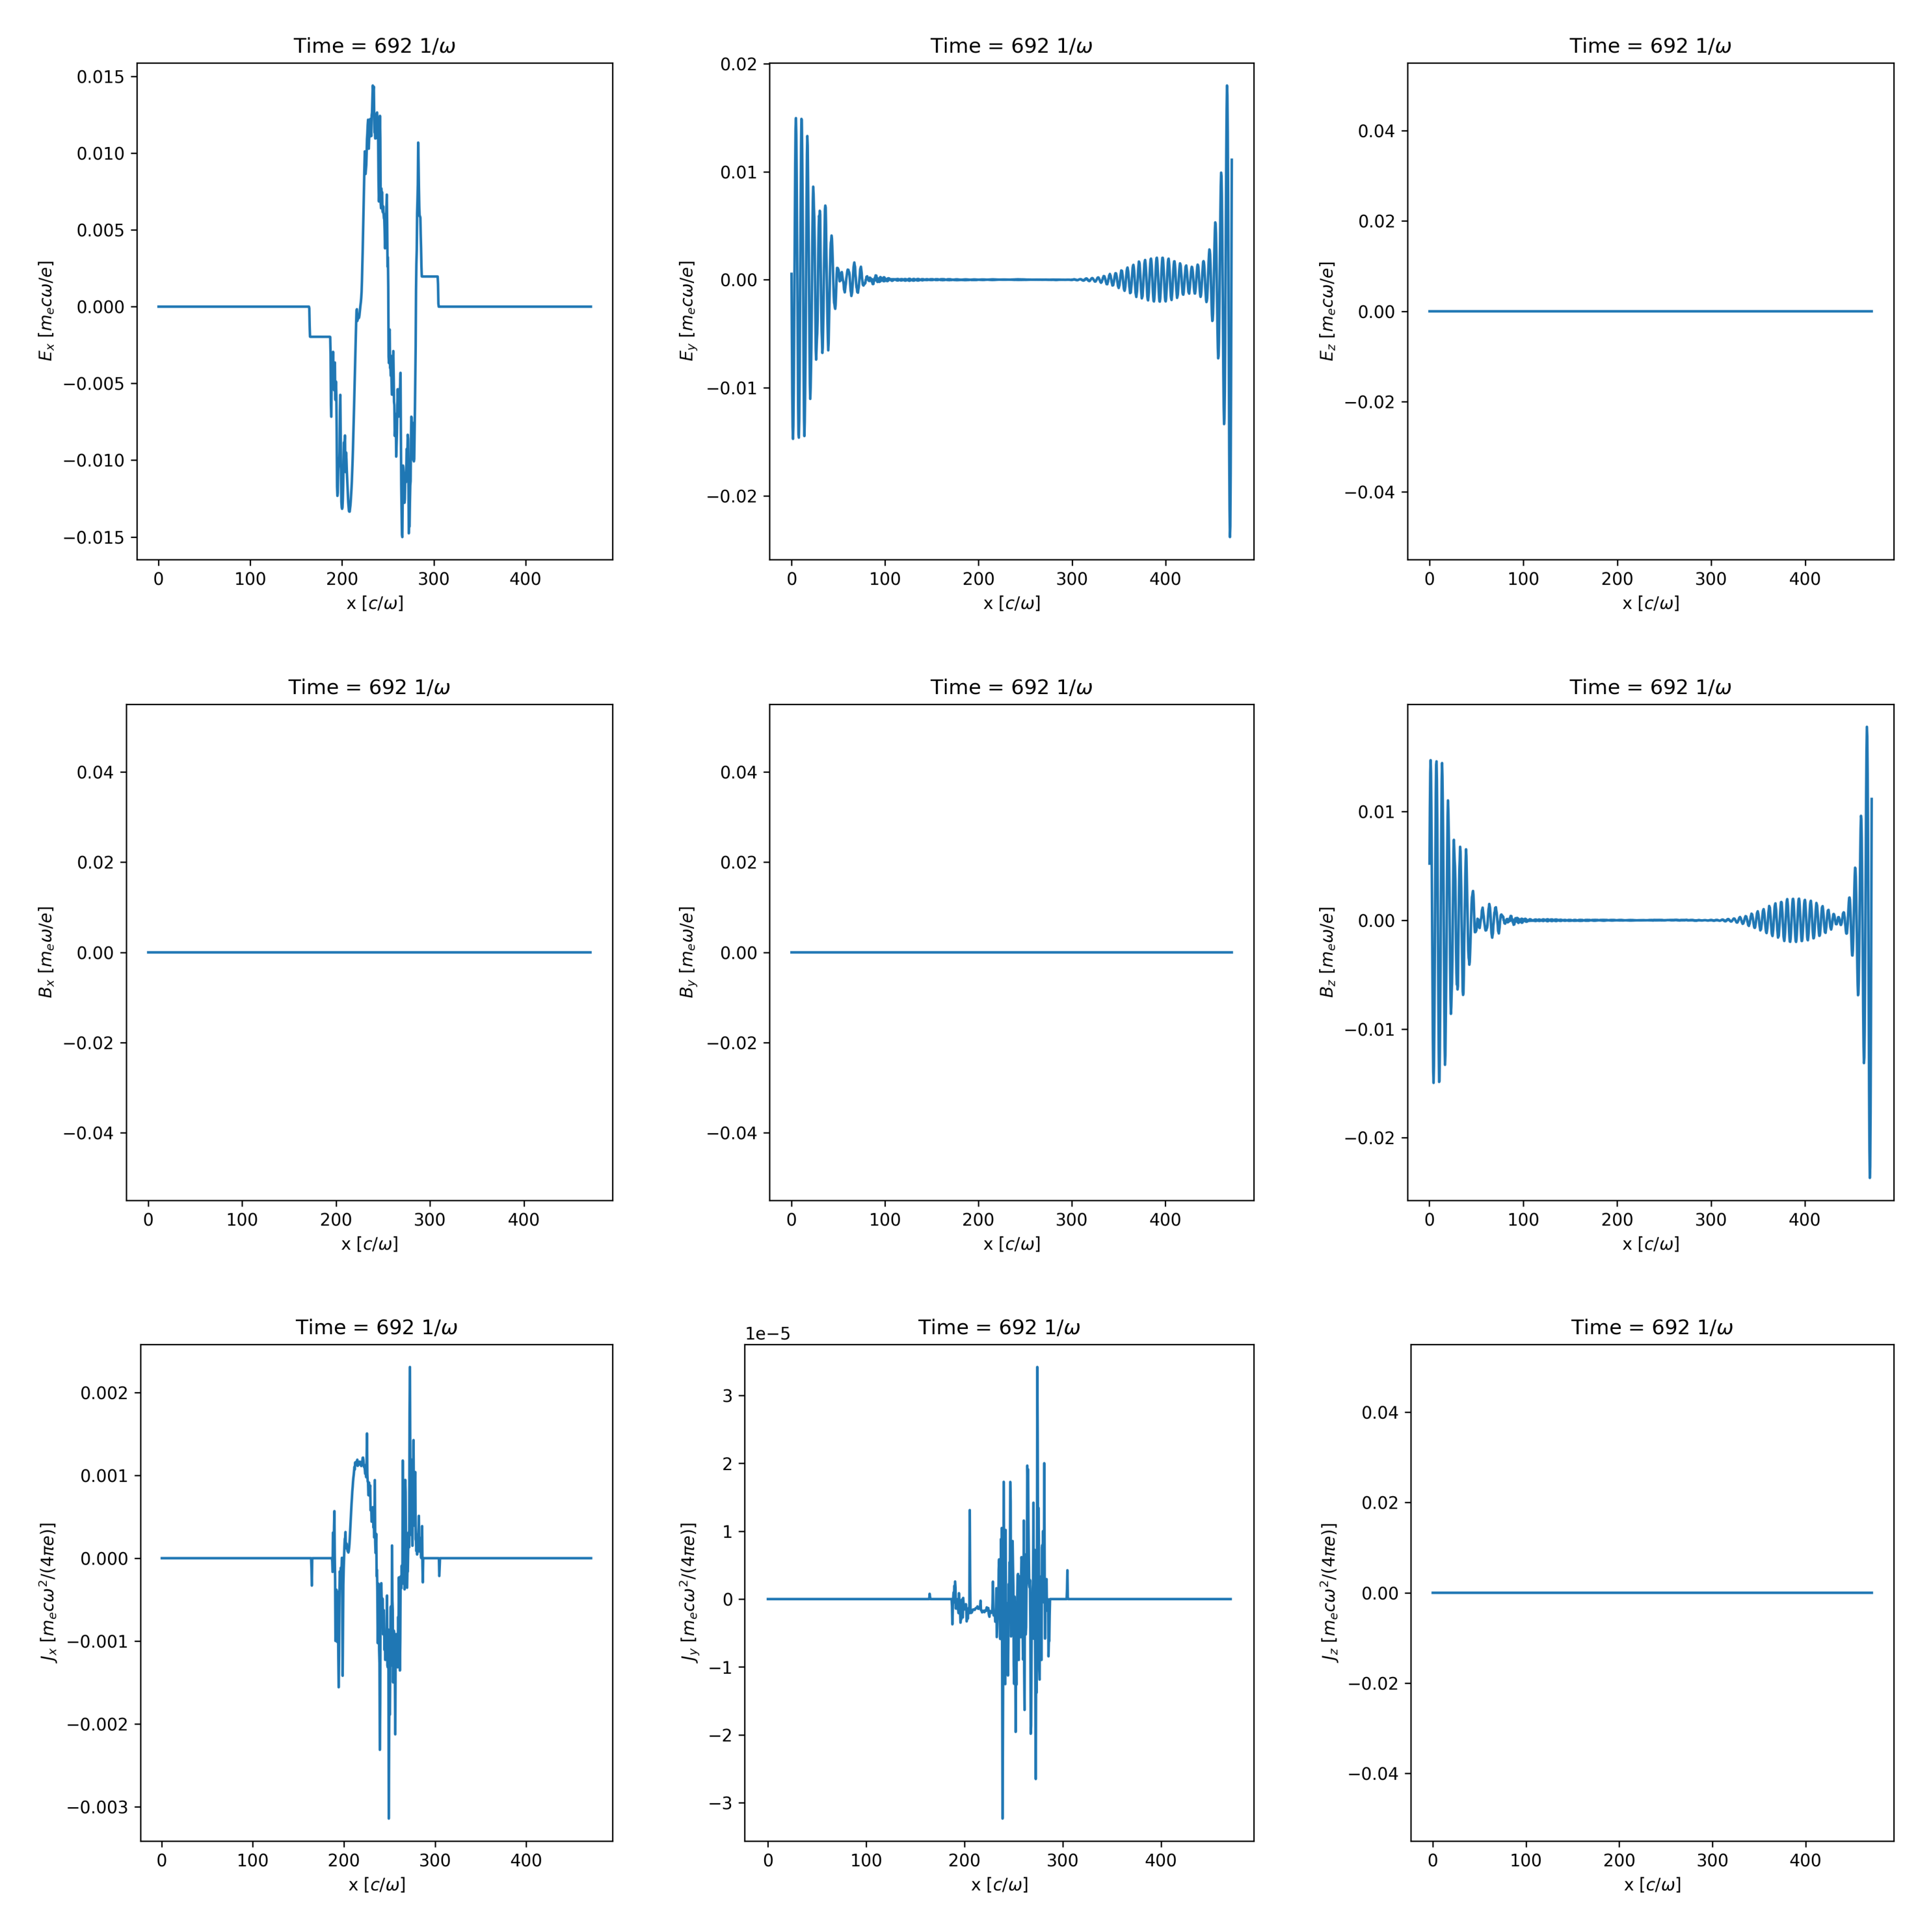

In [15]:
# Show electromagnetic and current fields
fig, ax = plt.subplots(3, 3, figsize=(10, 10), dpi=300)
ax=ax.flatten()
for i in t_diags:
    for j, string in enumerate(['E_x', 'E_y', 'E_z','B_x', 'B_y', 'B_z','J_x', 'J_y', 'J_z']):        
        img = plt.imread('./Data/%s_%s.png'%(string,i))
        imgplot = ax[j].imshow(img)
        ax[j].axis('off')
    display.clear_output(wait=True)
    display.display(pl.gcf())
plt.close()

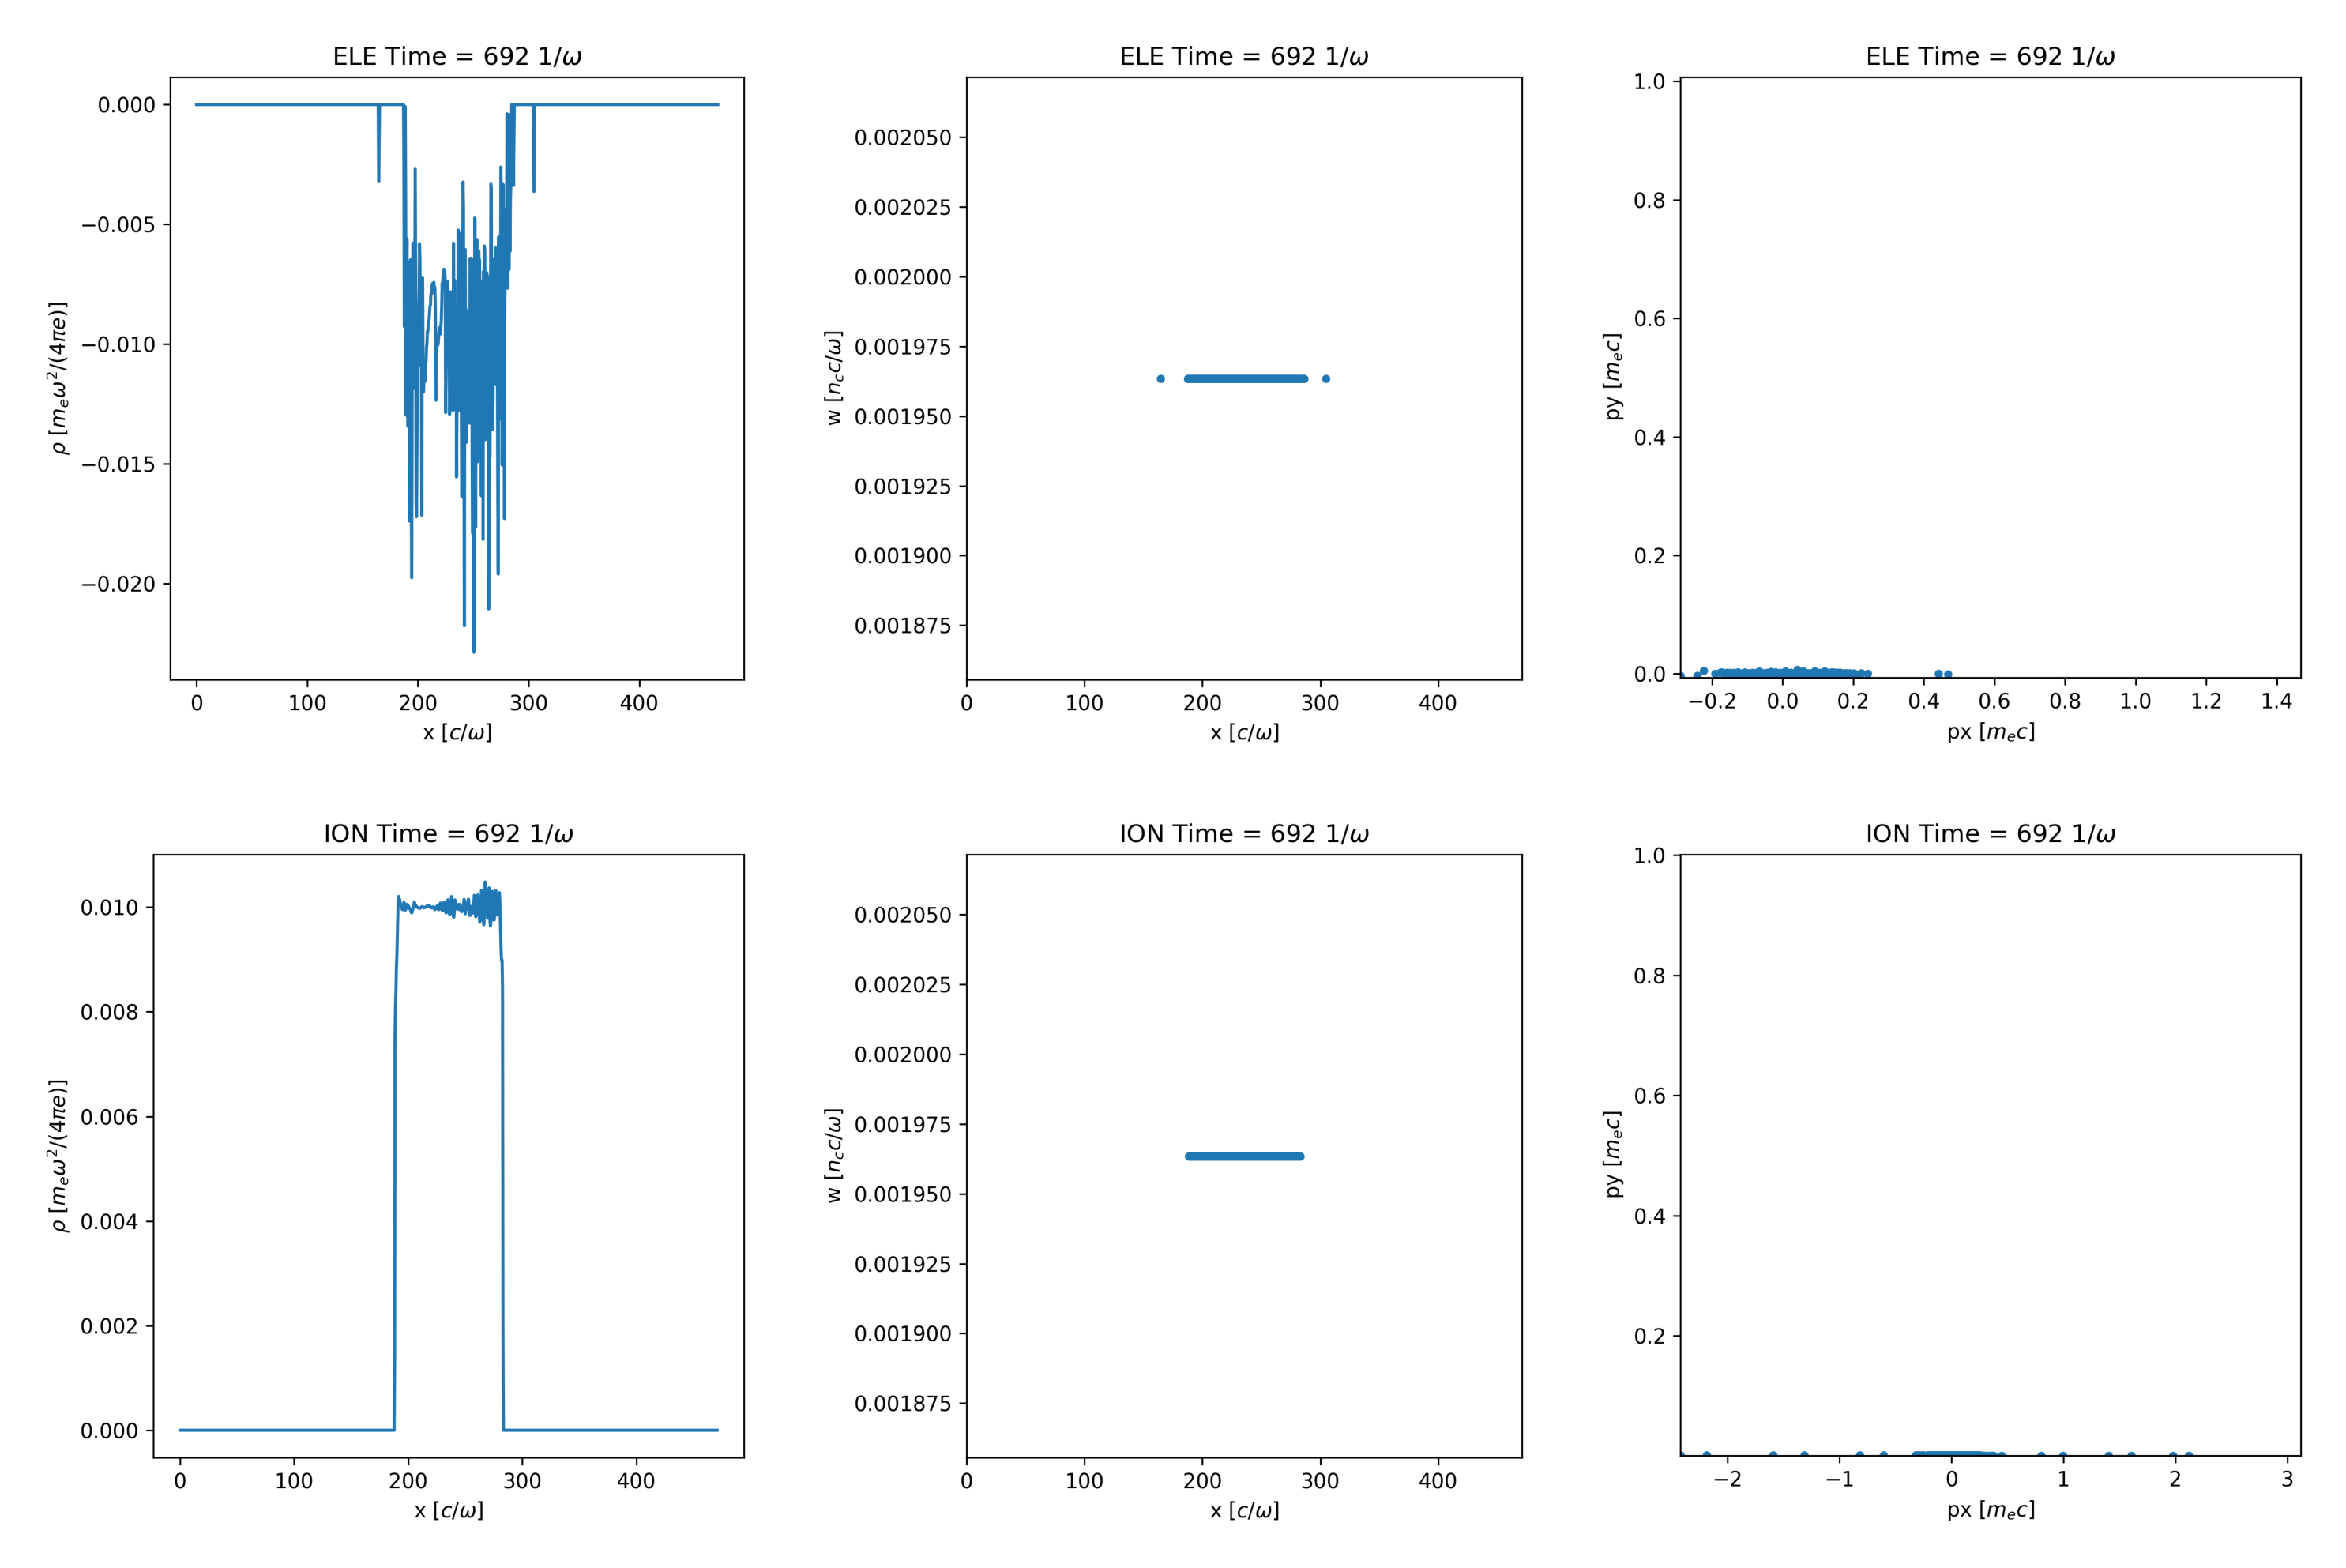

In [16]:
# Show charge density and particles
fig, ax = plt.subplots(2, 3, figsize=(10, 10), dpi=300)
for i in t_diags:
    for j, spe in enumerate(species_list):
        for k, string in enumerate(['_rho', '_pos', '_mom']):        
            img = mpimg.imread('./Data/%s%s_%s.png'%(spe.name,string,i))
            imgplot = ax[j,k].imshow(img)
            ax[j,k].axis('off')
    display.clear_output(wait=True)
    display.display(pl.gcf())
plt.close()

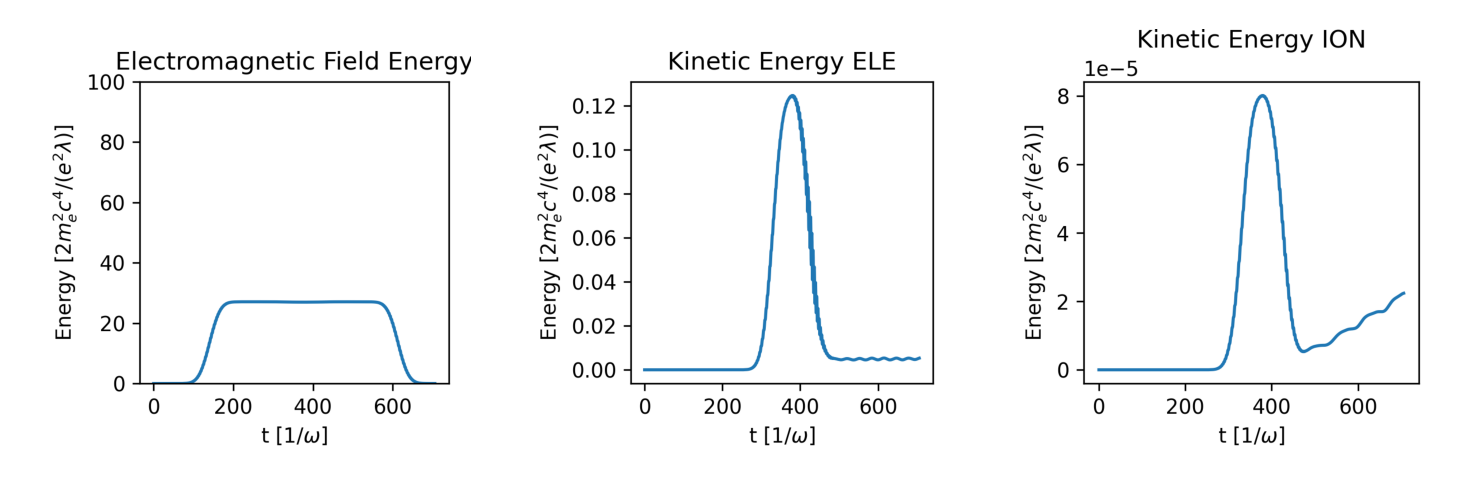

In [17]:
# Show evolution of energy in the simulation
fig, ax = plt.subplots(1, 3, figsize=(5, 10), dpi=300)
img = mpimg.imread('./Data/EM_energy.png')
imgplot = ax[0].imshow(img)
ax[0].axis('off')
for j, spe in enumerate(species_list):     
    img = mpimg.imread('./Data/kinetic_energy_%s.png'%(spe.name))
    imgplot = ax[j+1].imshow(img)
    ax[j+1].axis('off')
display.display(pl.gcf())
plt.close()